In [1]:
import jax
import jax.numpy as jnp
import specq_jax as sqj
import specq_dev as sqd
import numpyro
from numpyro.contrib.module import random_flax_module
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, TraceMeanField_ELBO, autoguide, init_to_feasible
from functools import partial
import optax
from pathlib import Path

2024-10-10 11:27:12,819	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-10 11:27:13,323	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# https://arxiv.org/abs/1505.05424

## Generate some data

In [3]:
key = jax.random.PRNGKey(0)
key, pulse_key, transformer_key, train_key, model_key = jax.random.split(key, 5)
config, pulse_sequence, pulse_parameters, unitaries, hamiltonian = (
    sqj.utils.testing.gen_mock_data(key=pulse_key, batch_size=int(1500))
)

# Generate noisy expectation values
# Wo_params, noise_transfomer = sqj.utils.testing.gen_Wo_params_v2(
#     transformer_key, pulse_sequence, pulse_parameters
# )

# expvals = sqj.core.get_predict_expectation_value(
#     Wos_params=Wo_params,
#     unitaries=unitaries[:, -1, :, :],
#     evaluate_expectation_values=sqd.shared.default_expectation_values,
# )

# Generate noiseless expectation values
# Calculate the expectation values with shot estimation.
expvals = []
final_unitaries = unitaries[:, -1, :, :]

plus_projectors = {
    "X": sqd.shared.State.from_label("+", dm=True),
    "Y": sqd.shared.State.from_label("r", dm=True),
    "Z": sqd.shared.State.from_label("0", dm=True),
}

for exp in sqd.shared.default_expectation_values:

    key, sample_key = jax.random.split(key)
    sample_keys = jax.random.split(sample_key, num=final_unitaries.shape[0])

    # expval = jax.vmap(calculate_shots_expectation_value, in_axes=(0, None, 0, None, None))(
    #     sample_keys, exp.get_density_matrix(), final_unitaries, plus_projectors[exp.observable], SHOTS
    # )

    expval = jax.vmap(sqj.core.calculate_exp, in_axes=(0, None, None))(final_unitaries, exp.get_operator(), exp.get_state())

    expvals.append(expval)

expvals = jnp.array(expvals)

unitaries = unitaries[:, -1, :, :]

c:\Users\natch\specq-jax\venv\lib\site-packages\equinox\_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)
c:\Users\natch\specq-jax\venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\natch\specq-jax\venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\natch\specq-jax\venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
 

## Load data

In [5]:
path = Path("0022")
exp_data, pulse_parameters, unitaries, expectations, pulse_sequence, simulator = (
    sqj.data.load_data(path)
)

pulse_parameters = jnp.array(pulse_parameters)
expvals = jnp.array(expectations.T)
unitaries = jnp.array(unitaries)

c:\Users\natch\specq-jax\venv\lib\site-packages\equinox\_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)
c:\Users\natch\specq-jax\venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\natch\specq-jax\venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\natch\specq-jax\venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
 

In [ ]:
def BNNModel(x, y=None, batch_size=None):
    base_module = sqj.model.BasicBlackBox(
        **{"feature_size": 9, "hidden_sizes_1": [29, 13], "hidden_sizes_2": [46, 32]}
    )
    net = random_flax_module(
        "nn",
        base_module,
        dist.Normal(0, 1.0),
        input_shape=(batch_size, pulse_parameters.shape[1]),
        training=False,
    )

    with numpyro.plate("batch", x.shape[0], subsample_size=batch_size, dim=-1) as ind:

        batch_x = x[ind]
        batch_y = y[ind] if y is not None else None

        pred = net(batch_x, training=True)

        predict_expvals = sqj.core.get_predict_expectation_value(
            Wos_params=pred,
            unitaries=unitaries[ind],
            evaluate_expectation_values=sqd.shared.default_expectation_values,
        )

        for idx, exp in enumerate(sqd.shared.default_expectation_values):
            numpyro.sample(
                f"obs_{idx}",
                # dist.Normal(predict_expvals[idx], jnp.ones_like(predict_expvals[idx]) * 0.05),
                # dist.Beta(predict_expvals[idx], 1.0),
                dist.TruncatedNormal(predict_expvals[idx], 0.05, low=-1.0, high=1.0),
                obs=batch_y.T[idx] if batch_y is not None else None,
            )

In [7]:
n_iterations = 10_000

lr_schedule = optax.warmup_cosine_decay_schedule(
    init_value=1e-6,
    peak_value=1e-2,
    warmup_steps=1000,
    decay_steps=10000,
    end_value=1e-6,
)

optimiser = optax.adamw(learning_rate=lr_schedule)
# Automatic Guide Generation for Stan via NumPyro :  https://arxiv.org/abs/2110.11790
guide = autoguide.AutoDiagonalNormal(BNNModel, init_loc_fn=init_to_feasible)
svi = SVI(
    BNNModel,
    guide,
    numpyro.optim.optax_to_numpyro(optimiser),
    TraceMeanField_ELBO(),
)

svi_result = svi.run(
    jax.random.PRNGKey(0),
    n_iterations,
    x=jnp.array(pulse_parameters),
    y=expvals.T, 
    # y=jnp.array(expectations),
    batch_size=100,
)

/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 10000/10000 [01:11<00:00, 140.54it/s, init loss: 1718411.8273, avg. loss [9501-10000]: -54883.3656]


In [70]:
params, losses = svi_result.params, svi_result.losses
predictive = Predictive(BNNModel, guide=guide, params=params, num_samples=1000)

y_pred = predictive(jax.random.PRNGKey(1), pulse_parameters[:100])

recovered_y = []
std = []
for idx, exp in enumerate(sqd.shared.default_expectation_values):
    recovered_y.append(y_pred[f"obs_{idx}"].mean(axis=0))
    std.append(y_pred[f"obs_{idx}"].std(axis=0))

recovered_y = jnp.array(recovered_y).T
std = jnp.array(std).T

In [67]:
# -*- coding: utf-8 -*-
"""
Integrated Code with Optimal Experimental Design (Avoiding Global Variables)
"""

import jax
import jax.numpy as jnp
import specq_jax as sqj  # Custom module, ensure it's installed
import specq_dev as sqd  # Custom module, ensure it's installed
import numpyro
from numpyro.contrib.module import random_flax_module
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, TraceMeanField_ELBO, autoguide, init_to_feasible
import optax
from functools import partial
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed
key = jax.random.PRNGKey(0)

# Load your data (Modify the path to your actual data)
path = Path("0022")
exp_data, pulse_parameters, unitaries, expectations, pulse_sequence, simulator = sqj.data.load_data(path)

# Convert data to JAX arrays
pulse_parameters = jnp.array(pulse_parameters)
expvals = jnp.array(expectations.T)  # Shape: [num_experiments, num_expectations]
unitaries = jnp.array(unitaries)

# Partition data into initial dataset and candidate experiments
initial_size = 100  # Number of initial data points
x_data = pulse_parameters[:initial_size]
y_data = expvals[:, :initial_size]  # Shape: [num_experiments, num_exps]
unitaries_data = unitaries[:initial_size]

# Candidate experiments
x_candidates = pulse_parameters[initial_size:]
y_candidates = expvals[:, initial_size:]
unitaries_candidates = unitaries[initial_size:]

# Define the Bayesian Neural Network model
def BNNModel(x, y=None, unitaries=None, batch_size=None):
    base_module = sqj.model.BasicBlackBox(
        feature_size=9, hidden_sizes_1=[29, 13], hidden_sizes_2=[46, 32]
    )
    net = random_flax_module(
        "nn",
        base_module,
        dist.Normal(0, 1.0),
        input_shape=(batch_size or x.shape[0], x.shape[1]),
        training=False,
    )

    with numpyro.plate("batch", x.shape[0], subsample_size=batch_size, dim=-1) as ind:
        batch_x = x[ind]
        batch_y = y[ind] if y is not None else None
        batch_unitaries = unitaries[ind]

        pred = net(batch_x, training=True)

        predict_expvals = sqj.core.get_predict_expectation_value(
            Wos_params=pred,
            unitaries=batch_unitaries,
            evaluate_expectation_values=sqd.shared.default_expectation_values,
        )

        for idx, exp in enumerate(sqd.shared.default_expectation_values):
            numpyro.sample(
                f"obs_{idx}",
                dist.TruncatedNormal(predict_expvals[:, idx], 0.05, low=-1.0, high=1.0),
                obs=batch_y[:, idx] if batch_y is not None else None,
            )

# Optimization settings
n_iterations = 10  # Adjust based on your computational resources
lr_schedule = optax.warmup_cosine_decay_schedule(
    init_value=1e-6,
    peak_value=1e-2,
    warmup_steps=1000,
    decay_steps=10000,
    end_value=1e-6,
)
optimizer = optax.adamw(learning_rate=lr_schedule)
guide = autoguide.AutoDiagonalNormal(BNNModel, init_loc_fn=init_to_feasible)
svi = SVI(
    BNNModel,
    guide,
    numpyro.optim.optax_to_numpyro(optimizer),
    TraceMeanField_ELBO(),
)

# Define the predictive function
def predictive_fn(x_new, unitaries_new, params, guide, num_samples=100):
    predictive = Predictive(BNNModel, guide=guide, params=params, num_samples=num_samples)
    y_pred = predictive(
        jax.random.PRNGKey(1),
        x_new,
        unitaries=unitaries_new,
        batch_size=x_new.shape[0],
    )
    num_exps = len(sqd.shared.default_expectation_values)
    y_samples = jnp.stack([y_pred[f"obs_{idx}"] for idx in range(num_exps)], axis=-1)
    return y_samples  # Shape: [num_samples, num_candidates, num_exps]

# Define the acquisition function (Predictive Entropy)
def predictive_entropy_acquisition(x_candidates, unitaries_candidates, params, guide):
    y_samples = predictive_fn(x_candidates, unitaries_candidates, params, guide, num_samples=100)  # Shape: [num_samples, num_candidates, num_exps]
    y_mean = jnp.mean(y_samples, axis=0)
    y_std = jnp.std(y_samples, axis=0)
    # Compute differential entropy for Gaussian assumption
    entropy = 0.5 * jnp.log(2 * jnp.pi * jnp.e * y_std**2)
    total_entropy = jnp.sum(entropy, axis=-1)  # Sum over outputs
    return total_entropy  # Shape: [num_candidates]

# Simulate performing the experiment using existing data
def perform_experiment(y_candidates, idx):
    # Simulate the experiment by returning the corresponding observation
    y_new = y_candidates[idx]
    return y_new  # Shape: [num_exps]

# Number of OED iterations
num_iterations = 5  # Adjust as needed

for iteration in range(num_iterations):
    print(f"Iteration {iteration+1}/{num_iterations}")

    # Retrain the model with current data
    svi_result = svi.run(
        jax.random.PRNGKey(iteration),
        n_iterations,
        x=x_data,
        y=y_data,
        unitaries=unitaries_data,
        batch_size=100,
    )
    params, losses = svi_result.params, svi_result.losses

    # Update guide and predictive function
    guide = autoguide.AutoDiagonalNormal(BNNModel, init_loc_fn=init_to_feasible)

    # Evaluate acquisition function on candidate experiments
    acquisition_values = predictive_entropy_acquisition(x_candidates, unitaries_candidates, params, guide)

    # Select the candidate with maximum acquisition value
    max_idx = int(jnp.argmax(acquisition_values))
    x_opt = x_candidates[max_idx]
    unitary_opt = unitaries_candidates[max_idx]

    # Simulate performing the experiment (fetch corresponding observation)
    y_new = perform_experiment(y_candidates, max_idx)

    # Update dataset with new data point
    x_data = jnp.vstack([x_data, x_opt[None, :]])
    y_data = jnp.vstack([y_data, y_new[None, :]])
    unitaries_data = jnp.vstack([unitaries_data, unitary_opt[None, :, :]])

    # Remove the selected candidate from the pool
    x_candidates = jnp.delete(x_candidates, max_idx, axis=0)
    y_candidates = jnp.delete(y_candidates, max_idx, axis=0)
    unitaries_candidates = jnp.delete(unitaries_candidates, max_idx, axis=0)

    # Optionally, visualize or analyze the results after each iteration
    # For example, print the newly acquired data point
    print(f"Selected experimental condition index: {initial_size + max_idx}")
    print(f"New experimental conditions: {x_opt}")
    print(f"Observed expectation values: {y_new}")

# After iterations, you can proceed with analysis or further model refinement

# Optionally, visualize the loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('SVI Loss over Iterations')
plt.show()

# Make final predictions with the trained model
predictive = Predictive(BNNModel, guide=guide, params=params, num_samples=1000)
y_pred = predictive(
    jax.random.PRNGKey(1),
    x_data,
    unitaries=unitaries_data,
    batch_size=x_data.shape[0],
)

# Process predictions as needed for analysis or visualization
recovered_y = []
std = []
for idx, exp in enumerate(sqd.shared.default_expectation_values):
    recovered_y.append(y_pred[f"obs_{idx}"].mean(axis=0))
    std.append(y_pred[f"obs_{idx}"].std(axis=0))

recovered_y = jnp.array(recovered_y).T  # Shape: [num_experiments, num_exps]
std = jnp.array(std).T  # Shape: [num_experiments, num_exps]

# Example: Plot predicted vs observed expectation values for the last iteration
sample_idx = -1  # Last data point
num_exps = len(sqd.shared.default_expectation_values)

fig, axes = plt.subplots(num_exps, 1, figsize=(8, num_exps * 2))
for idx, ax in enumerate(axes):
    exp = sqd.shared.default_expectation_values[idx]
    sns.histplot(y_pred[f"obs_{idx}"][:, sample_idx], kde=True, stat="density", ax=ax)
    ax.axvline(y_data[sample_idx, idx], 0, 1, color="r", linestyle="--", label="Observed Value")
    ax.set_xlim(-1, 1)
    ax.set_title(f'Posterior Distribution {exp.initial_state}/{exp.observable}')
    ax.set_xlabel('Expectation Value')
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()


c:\Users\natch\specq-jax\venv\lib\site-packages\equinox\_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)
c:\Users\natch\specq-jax\venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\natch\specq-jax\venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\natch\specq-jax\venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
 

Iteration 1/5


ValueError: Incompatible shapes for broadcasting: shapes=[(100,), (18,)]

In [64]:
unitaries.shape

(700, 2, 2)

In [63]:
expvals[100:].shape

(0, 700)

c:\Users\natch\specq-jax\venv\lib\site-packages\equinox\_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)
c:\Users\natch\specq-jax\venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\natch\specq-jax\venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\natch\specq-jax\venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
 

Data loaded successfully.
Pulse Parameters Shape: (700, 30)
Expectations Shape: (700, 18)
Unitaries Shape: (700, 2, 2)
Total data points loaded: 700
Initial dataset size: 100
Candidate experiments size: 600

--- Iteration 1/5 ---
Training the model...


100%|██████████| 10000/10000 [02:35<00:00, 64.38it/s, init loss: 113941.3307, avg. loss [9501-10000]: -2055.6110]


Computing acquisition values...
Selected experimental condition index: 100
New experimental conditions: [ 0.97629398  8.91288023  0.16080651  0.87797691  5.38843247  1.65144219
  0.09261358  6.62259307  1.68194743  0.93480867  3.12334845 -1.65001543
  0.85873907  3.83703828 -0.36461384  0.30216302  4.94900732  1.2105993
  0.43301917  2.05280389 -1.82187826  0.69129713  1.55382505  0.1510048
  0.79475154  1.75045679 -0.83172842  0.64765871  2.43584798 -1.55109823]
Observed expectation values: [ 0.95917169 -1.03993235 -0.06007106 -0.0206896  -0.01784073 -0.06291992
 -0.04133674 -0.03942391 -0.81410702  0.73334636 -0.67389914  0.59313849
 -0.01046639 -0.07029426  0.59283313 -0.67359378 -0.81377924  0.73301858]


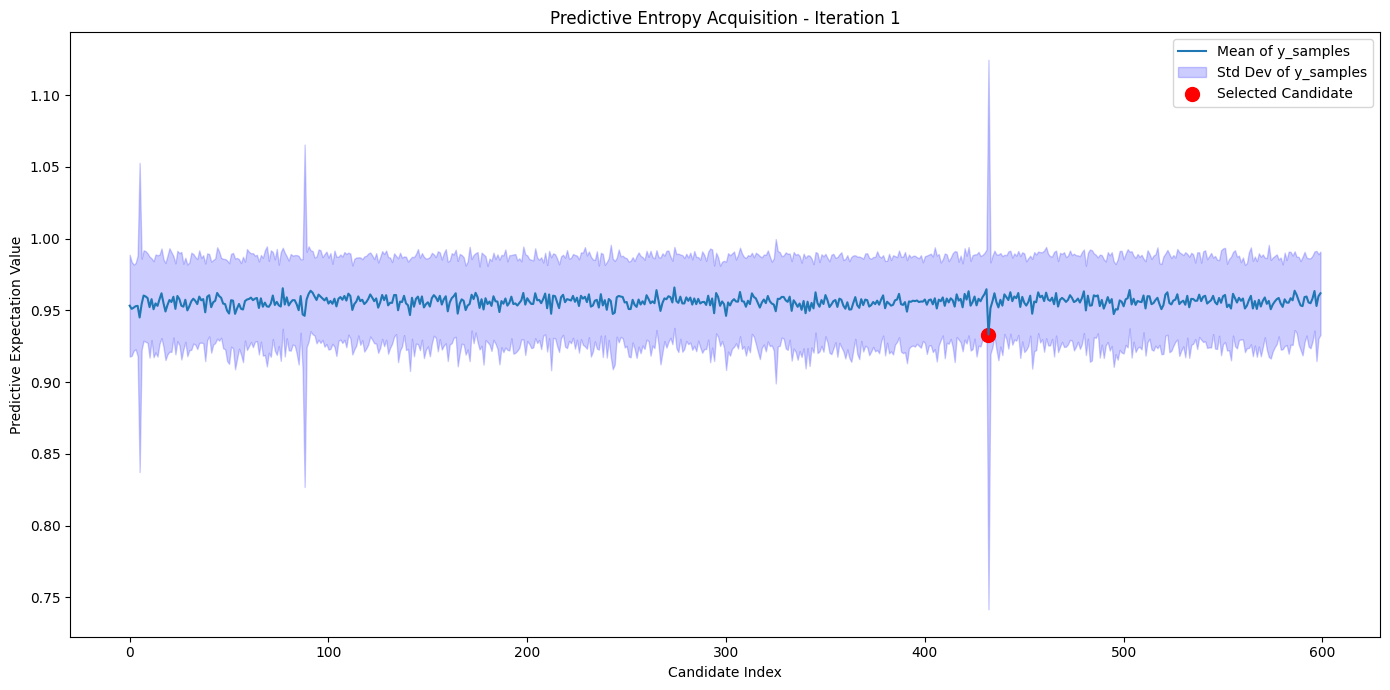


--- Iteration 2/5 ---
Training the model...


100%|██████████| 10000/10000 [05:12<00:00, 31.96it/s, init loss: 121907.2421, avg. loss [9501-10000]: -1842.4224]


Computing acquisition values...
Selected experimental condition index: 101
New experimental conditions: [ 0.5923559   8.66320048  1.5151647   0.33740266  5.67737608 -1.15923315
  0.93159121  5.39632066 -1.3588361   0.21842537  4.05276589 -0.45222585
  0.82253055  3.56228898  1.86987113  0.01508968  3.10698617  1.6235135
  0.05451871  2.74632706  1.36521411  0.391701    1.43774405  1.72013504
  0.38718911  1.18666395 -1.94069732  0.53333937  1.8312437  -1.45436349]
Observed expectation values: [ 0.99053854 -1.00907303 -0.02896649  0.01043199 -0.00868765 -0.00984685
 -0.00286637 -0.01566812  0.28750326 -0.30603775 -0.96419462  0.94566013
  0.00937209 -0.02790658  0.94547838 -0.96401287  0.28757172 -0.30610621]


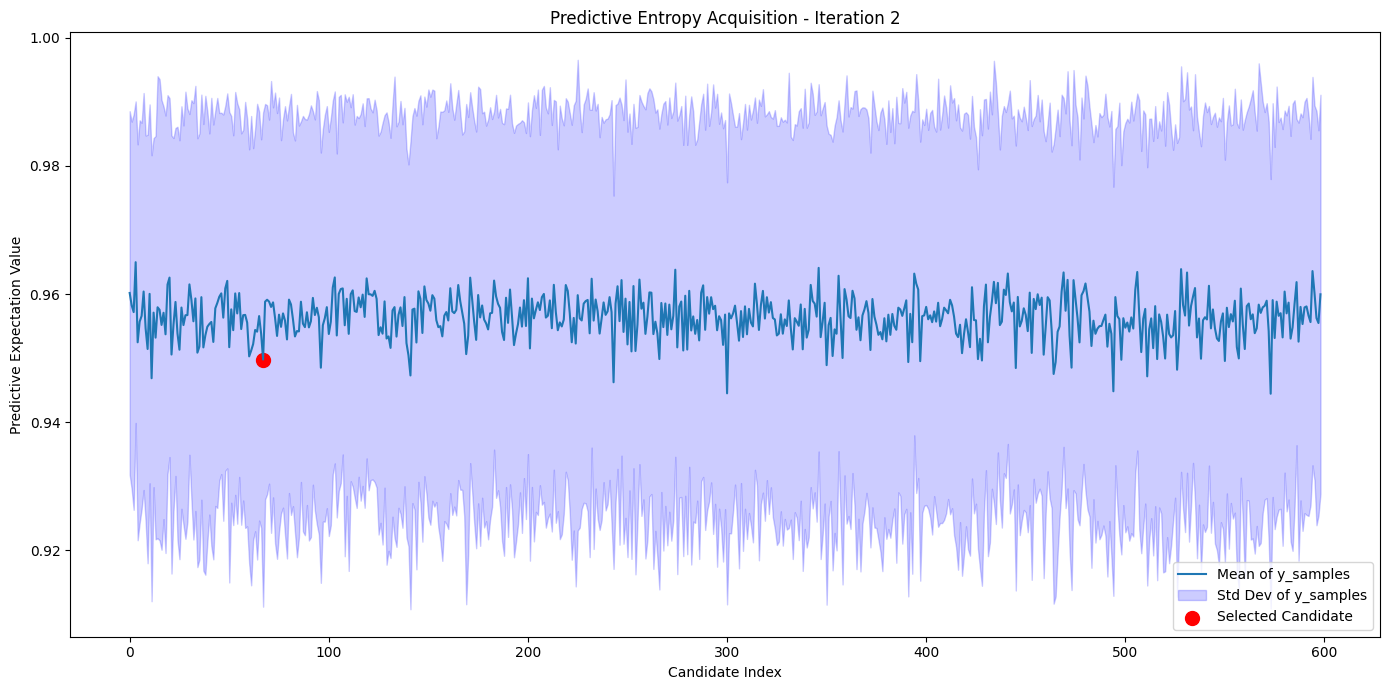


--- Iteration 3/5 ---
Training the model...


100%|██████████| 10000/10000 [02:32<00:00, 65.53it/s, init loss: 123294.6442, avg. loss [9501-10000]: -1953.9264]


Computing acquisition values...
Selected experimental condition index: 102
New experimental conditions: [ 7.63095967e-01  8.23832906e+00  1.08601480e+00  1.60408806e-01
  6.83602981e+00  8.05259301e-02  9.94013492e-01  6.07429911e+00
 -1.16790882e-01  8.67418048e-02  4.65655890e+00 -1.89623651e+00
  4.48862600e-04  4.33355832e+00 -1.65423220e+00  9.16810568e-01
  3.03614760e+00  9.76988609e-01  8.99835774e-01  2.39578075e+00
 -2.01146509e-01  8.08345789e-01  2.77460313e+00  1.88920520e+00
  2.65540278e-01  1.82989209e+00  7.54762989e-01  5.44287240e-01
  1.10190286e+00 -1.92977429e+00]
Observed expectation values: [ 1.00178732 -0.9965565  -0.02974708  0.0349779   0.02727629 -0.02204546
  0.02011001 -0.01487919 -0.20288673  0.20811755 -0.97588487  0.9811157
  0.03934998 -0.03411916  0.98073685 -0.97550602 -0.20215038  0.20738121]


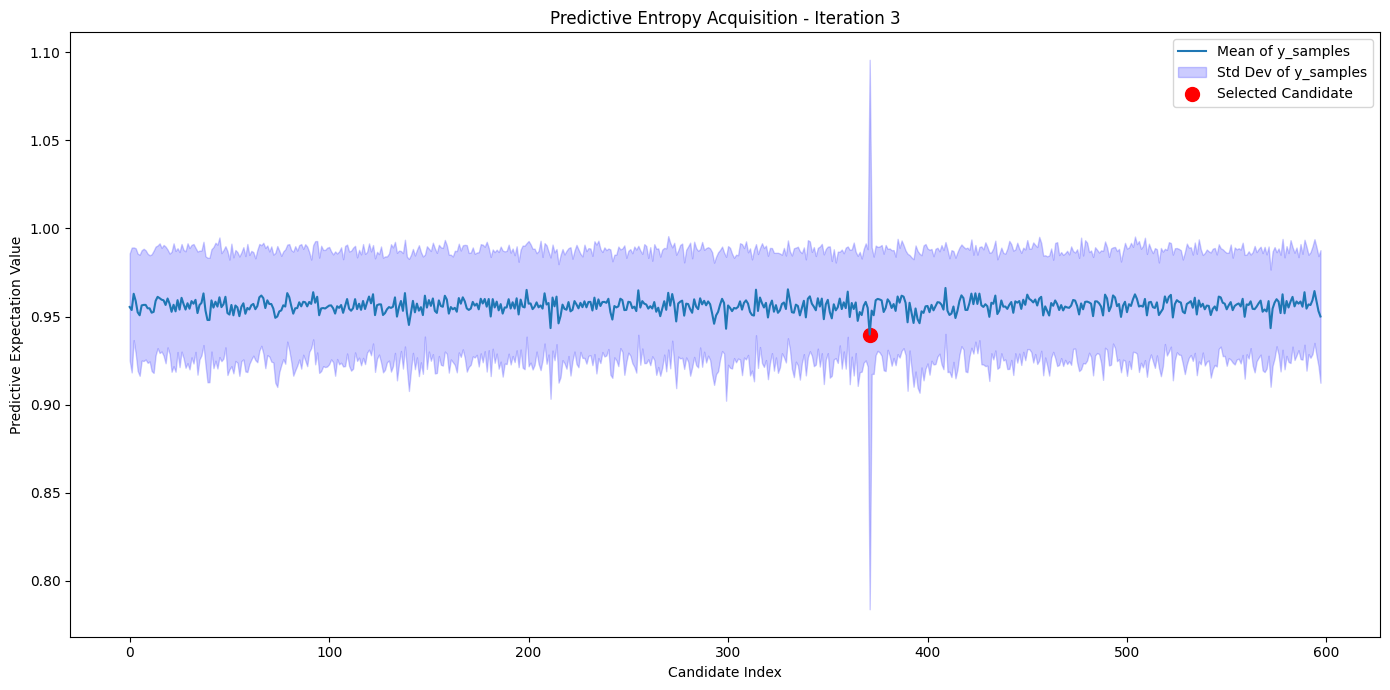


--- Iteration 4/5 ---
Training the model...


100%|██████████| 10000/10000 [02:19<00:00, 71.49it/s, init loss: 127044.4808, avg. loss [9501-10000]: -2254.2526]


Computing acquisition values...
Selected experimental condition index: 103
New experimental conditions: [ 0.87379266  8.57263194  1.04414334  0.96821542  5.71521184  1.31677907
  0.82287537  6.73288445  0.87300536  0.065269    3.05990153  1.9156662
  0.94523931  4.6220436  -0.62575259  0.17790328  3.17315836  1.38422653
  0.6355549   2.87189206 -0.8553924   0.1312065   1.84098749  1.05539037
  0.2784973   1.08891186 -0.69844628  0.6793804   1.08105362 -0.63393577]
Observed expectation values: [ 1.02709136 -0.96541633 -0.00370703  0.06538206  0.11011523 -0.0484402
  0.05004293  0.0116321  -0.77463338  0.83630841 -0.56148654  0.62316157
  0.11515498 -0.05347994  0.62246519 -0.56079016 -0.77095252  0.83262755]


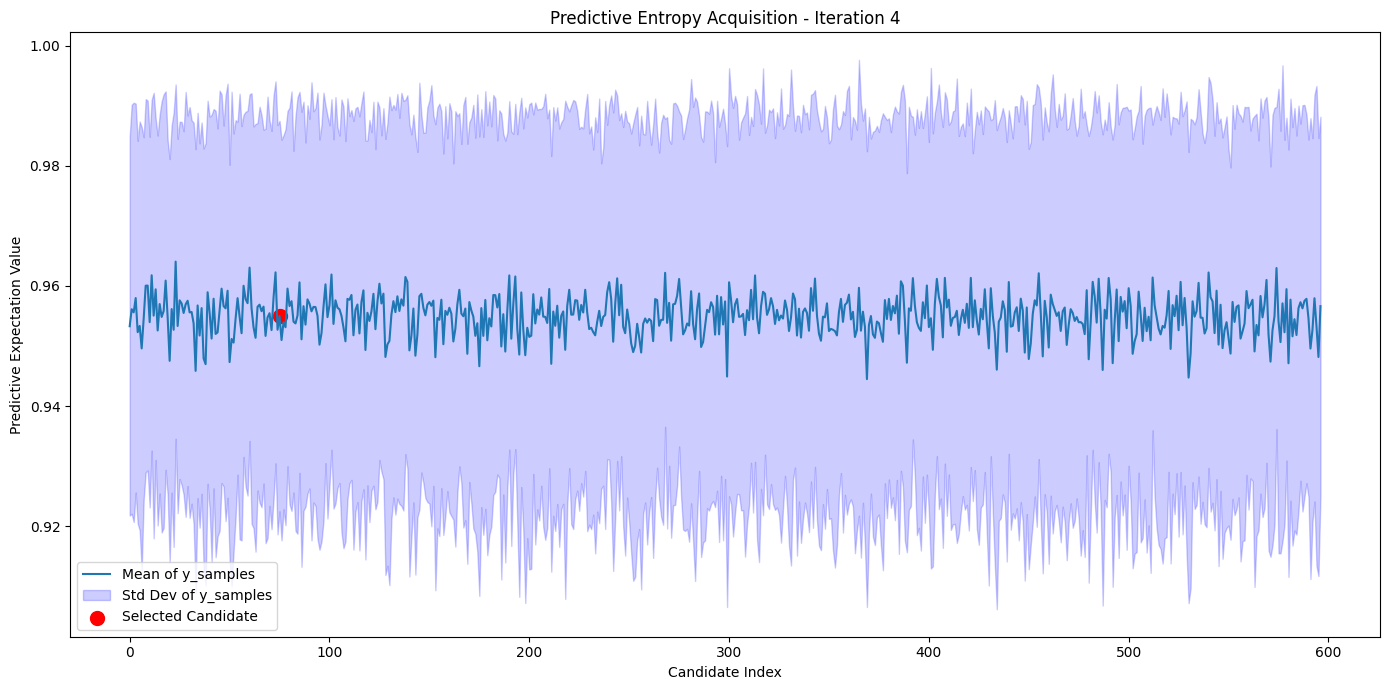


--- Iteration 5/5 ---
Training the model...


100%|██████████| 10000/10000 [03:31<00:00, 47.31it/s, init loss: 129582.6119, avg. loss [9501-10000]: -2250.3912]


Computing acquisition values...
Selected experimental condition index: 104
New experimental conditions: [ 0.78533315  7.97797091 -1.38311193  0.8163418   5.39379062 -0.01195864
  0.90255714  6.0165711  -0.91872978  0.5208036   3.27637396  0.56097998
  0.37560433  3.27138486  0.32185984  0.03918984  3.49440316  0.84072402
  0.23564492  1.27283287  1.40917649  0.95477892  1.60072499  0.17469535
  0.23985221  2.23033223  1.81738277  0.01951979  1.31329291  1.89668152]
Observed expectation values: [ 0.98674662 -1.00980371  0.01690053 -0.03995763 -0.06289466  0.03983757
 -0.05069453  0.02763744 -0.34081392  0.31775683 -0.95494636  0.93188926
 -0.05526316  0.03220606  0.93227383 -0.95533093 -0.33913251  0.31607541]


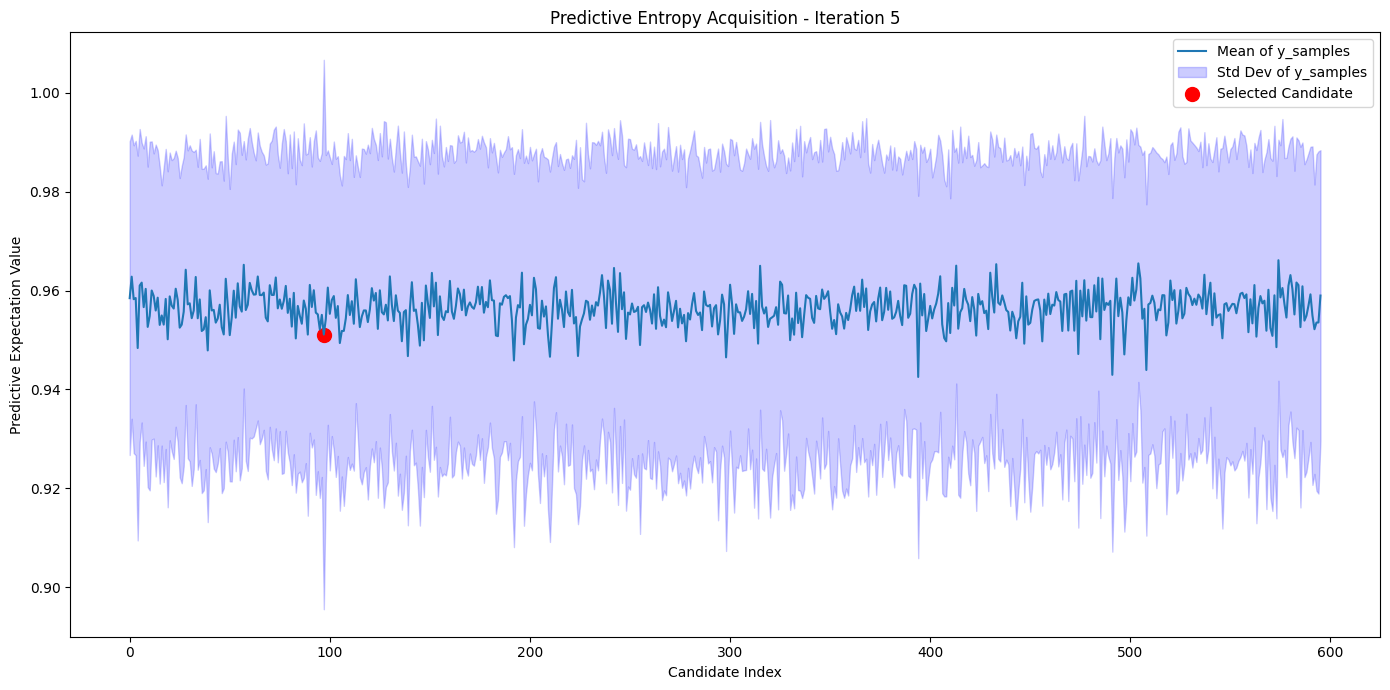


Final training to obtain params for predictions...


100%|██████████| 10000/10000 [07:42<00:00, 21.64it/s, init loss: 122335.4309, avg. loss [9501-10000]: -1935.0975] 


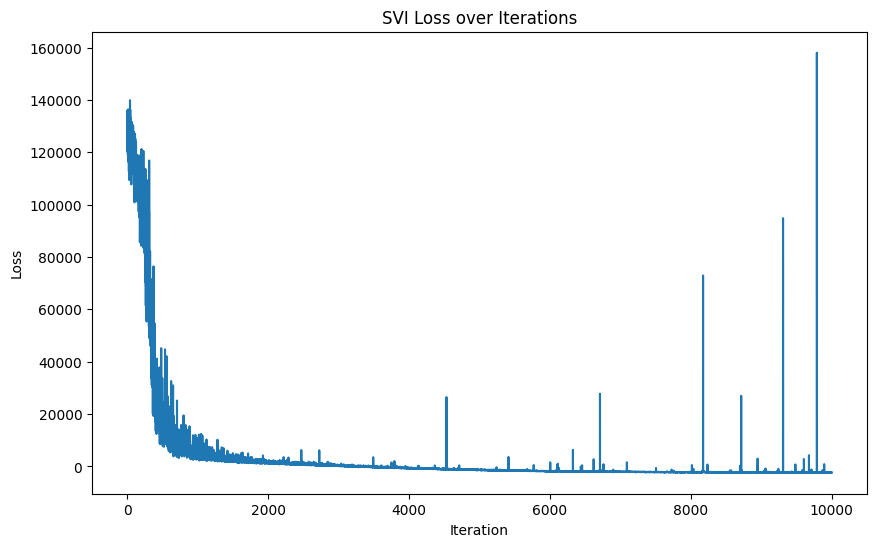

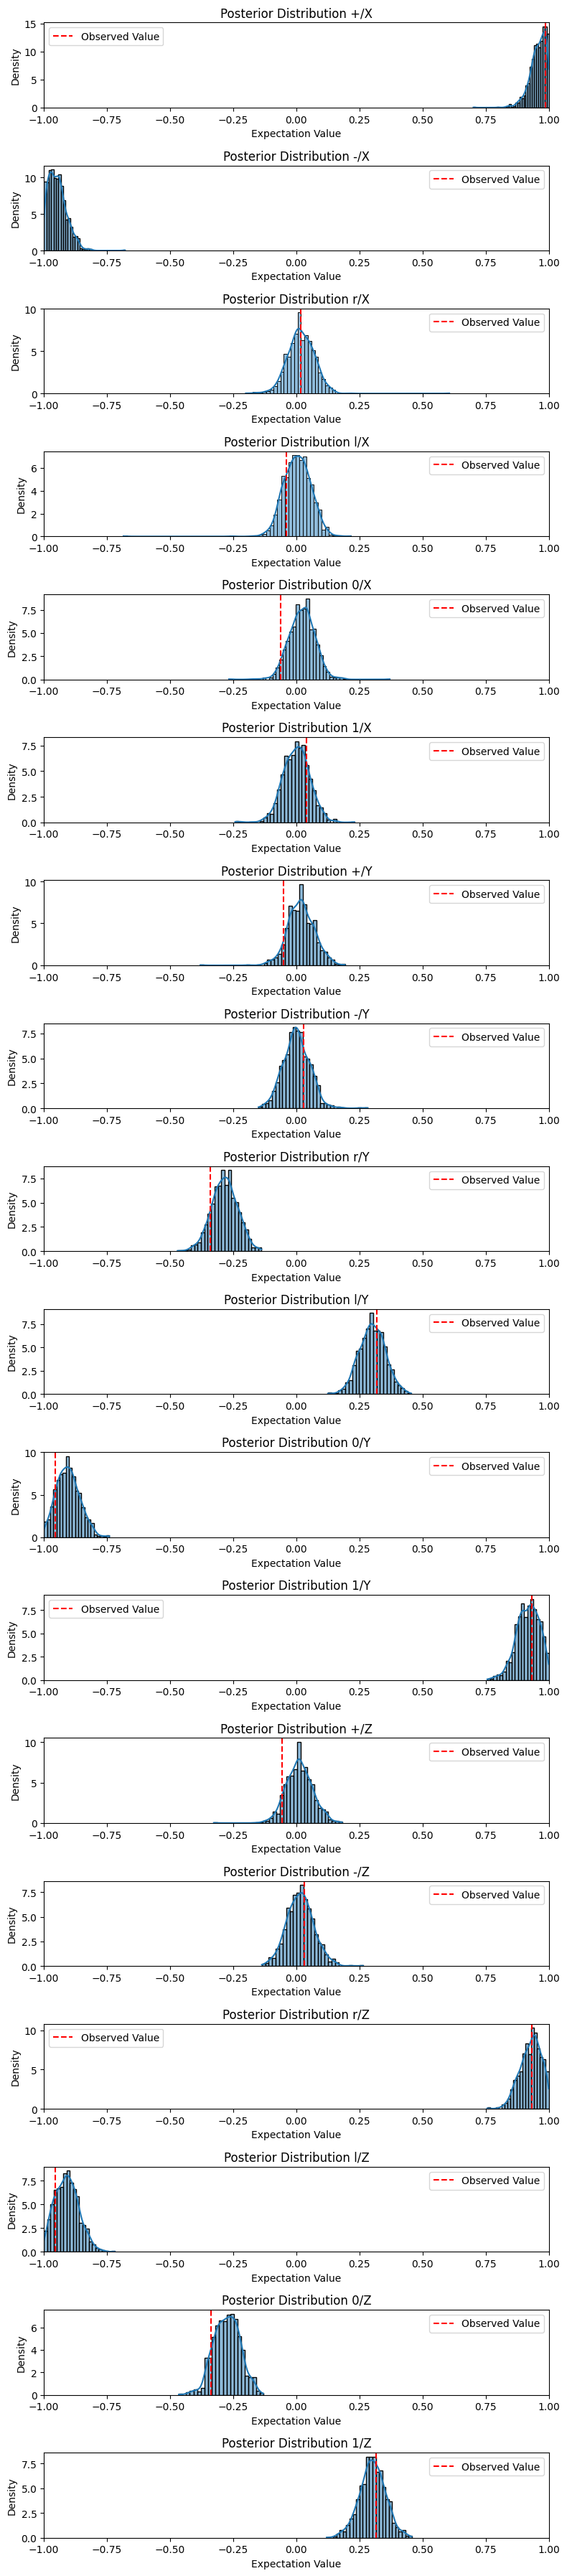

In [83]:
# -*- coding: utf-8 -*-
"""
Integrated Code with Optimal Experimental Design (Refactored and Enhanced)
"""
import jax
import jax.numpy as jnp
import specq_jax as sqj  # Custom module, ensure it's installed
import specq_dev as sqd  # Custom module, ensure it's installed
import numpyro
from numpyro.contrib.module import random_flax_module
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, TraceMeanField_ELBO, autoguide, init_to_feasible
import optax
from functools import partial
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class OptimalExperimentalDesign:
    def __init__(self, data_path, initial_size=100, n_iterations=5000, oed_iterations=5, noise_std=0.05):
        """
        Initializes the Optimal Experimental Design process.

        Args:
            data_path (Path): Path to the data directory.
            initial_size (int): Number of initial data points.
            n_iterations (int): Number of SVI iterations per OED step.
            oed_iterations (int): Number of OED iterations.
            noise_std (float): Standard deviation of Gaussian noise added to simulate experimental noise.
        """
        self.noise_std = noise_std
        # Load data
        self.load_data(data_path)

        # Check total data size
        total_data = self.pulse_parameters.shape[0]
        print(f"Total data points loaded: {total_data}")

        # Adjust initial_size if necessary
        if total_data <= initial_size:
            adjusted_initial_size = max(total_data // 2, 1)
            print(f"Warning: Total data points ({total_data}) <= initial_size ({initial_size}). Reducing initial_size to {adjusted_initial_size}.")
            initial_size = adjusted_initial_size

        # Partition data
        self.partition_data(initial_size)

        # Optimization settings
        self.n_iterations = n_iterations
        self.oed_iterations = oed_iterations
        self.setup_optimization()

    def load_data(self, path):
        """
        Loads data from the specified path.

        Args:
            path (Path): Path to the data directory.
        """
        try:
            self.exp_data, self.pulse_parameters, self.unitaries, self.expectations, self.pulse_sequence, self.simulator = sqj.data.load_data(path)
            self.pulse_parameters = jnp.array(self.pulse_parameters)
            # Removed the transpose (.T) to maintain original shape
            self.expvals = jnp.array(self.expectations)  # Shape: [num_experiments, num_expectations]
            self.unitaries = jnp.array(self.unitaries)
            print("Data loaded successfully.")
            print(f"Pulse Parameters Shape: {self.pulse_parameters.shape}")
            print(f"Expectations Shape: {self.expvals.shape}")
            print(f"Unitaries Shape: {self.unitaries.shape}")
        except Exception as e:
            print(f"Error loading data: {e}")
            raise

    def partition_data(self, initial_size):
        """
        Partitions the data into initial dataset and candidate experiments.

        Args:
            initial_size (int): Number of initial data points.
        """
        self.x_data = self.pulse_parameters[:initial_size]
        self.y_data = self.expvals[:initial_size]  # Shape: [num_experiments, num_exps]
        self.unitaries_data = self.unitaries[:initial_size]

        # Candidate experiments
        self.x_candidates = self.pulse_parameters[initial_size:]
        self.unitaries_candidates = self.unitaries[initial_size:]

        print(f"Initial dataset size: {self.x_data.shape[0]}")
        print(f"Candidate experiments size: {self.x_candidates.shape[0]}")

        # Check if candidate pool is empty
        if self.x_candidates.shape[0] == 0:
            raise ValueError("Candidate experiments pool is empty. Please check the data or adjust the initial_size.")

    def setup_optimization(self):
        """
        Sets up the optimization parameters.
        """
        self.lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=1e-6,
            peak_value=1e-2,
            warmup_steps=1000,
            decay_steps=10000,
            end_value=1e-6,
        )
        self.optimizer = optax.adamw(learning_rate=self.lr_schedule)

        # Define the guide once
        self.guide = autoguide.AutoDiagonalNormal(self.BNNModel, init_loc_fn=init_to_feasible)

        # Define the SVI object once
        self.svi = SVI(
            self.BNNModel,
            self.guide,
            numpyro.optim.optax_to_numpyro(self.optimizer),
            TraceMeanField_ELBO(),
        )

    def BNNModel(self, x, y=None, unitaries=None, batch_size=None):
        """
        Defines the Bayesian Neural Network model.

        Args:
            x (jnp.ndarray): Input features.
            y (jnp.ndarray, optional): Observed targets.
            unitaries (jnp.ndarray, optional): Unitaries corresponding to x.
            batch_size (int, optional): Batch size for subsampling.

        Returns:
            None
        """
        base_module = sqj.model.BasicBlackBox(
            feature_size=9, hidden_sizes_1=[29, 13], hidden_sizes_2=[46, 32]
        )
        net = random_flax_module(
            "nn",
            base_module,
            dist.Normal(0, 1.0),
            input_shape=(batch_size or x.shape[0], x.shape[1]),
            training=False,
        )

        with numpyro.plate("batch", x.shape[0], subsample_size=batch_size, dim=-1) as ind:
            batch_x = x[ind]
            batch_y = y[ind] if y is not None else None
            batch_unitaries = unitaries[ind]

            pred = net(batch_x, training=True)

            predict_expvals = sqj.core.get_predict_expectation_value(
                Wos_params=pred,
                unitaries=batch_unitaries,
                evaluate_expectation_values=sqd.shared.default_expectation_values,
            )

            for idx, exp in enumerate(sqd.shared.default_expectation_values):
                numpyro.sample(
                    f"obs_{idx}",
                    dist.TruncatedNormal(predict_expvals[idx], 0.05, low=-1.0, high=1.0),
                    obs=batch_y[:, idx] if batch_y is not None else None,
                )

    def predictive_fn(self, x_new, unitary_new, params, guide, num_samples=100):
        """
        Generates posterior predictive samples for new inputs.

        Args:
            x_new (jnp.ndarray): New input data points.
            unitary_new (jnp.ndarray): New unitaries corresponding to x_new.
            params (dict): Trained parameters.
            guide (AutoGuide): Trained guide.
            num_samples (int): Number of posterior samples to draw.

        Returns:
            jnp.ndarray: Posterior predictive samples.
        """
        predictive = Predictive(self.BNNModel, guide=guide, params=params, num_samples=num_samples)
        y_pred = predictive(
            jax.random.PRNGKey(1),
            x_new,
            unitaries=unitary_new,
            batch_size=x_new.shape[0],
        )
        # num_exps = len(sqd.shared.default_expectation_values)
        # y_samples = jnp.stack([y_pred[f"obs_{idx}"] for idx in range(num_exps)], axis=-1)
        recovered_y = []
        std = []
        for idx, exp in enumerate(sqd.shared.default_expectation_values):
            recovered_y.append(y_pred[f"obs_{idx}"].mean(axis=0))
            std.append(y_pred[f"obs_{idx}"].std(axis=0))

        recovered_y = jnp.array(recovered_y).T
        std = jnp.array(std).T
        return recovered_y, std # Shape: [num_samples, num_candidates, num_exps]

    def predictive_entropy_acquisition(self, x_candidates, unitaries_candidates, params, guide):
        """
        Computes the predictive entropy for candidate experiments.

        Args:
            x_candidates (jnp.ndarray): Candidate input data points.
            unitaries_candidates (jnp.ndarray): Candidate unitaries.
            params (dict): Trained parameters.
            guide (AutoGuide): Trained guide.

        Returns:
            jnp.ndarray: Entropy values for each candidate.
        """
        y_means, y_std = self.predictive_fn(x_candidates, unitaries_candidates, params, guide, num_samples=100)
        # Compute differential entropy for Gaussian assumption
        entropy = 0.5 * jnp.log(2 * jnp.pi * jnp.e * y_std**2)
        total_entropy = jnp.sum(entropy, axis=-1)  # Sum over outputs
        return y_means, y_std, total_entropy  # Shape: [num_candidates]

    def perform_experiment(self, x_opt, unitary_opt, rng_key):
        """
        Simulates performing the experiment by computing expectation values with added noise.

        Args:
            x_opt (jnp.ndarray): Selected experimental conditions.
            unitary_opt (jnp.ndarray): Unitaries corresponding to x_opt.
            rng_key (jax.random.PRNGKey): Random key for noise generation.

        Returns:
            jnp.ndarray: Observed expectation values with noise.
        """
        y_new = []
        for exp in sqd.shared.default_expectation_values:
            # Compute the true expectation value using the simulator
            expval = sqj.core.calculate_exp(
                unitary=unitary_opt,
                operator=exp.get_operator(),
                initial_state=exp.get_state()
            )
            # Add Gaussian noise to simulate experimental uncertainty
            noise = jax.random.normal(rng_key, shape=expval.shape) * self.noise_std
            expval_noisy = expval + noise
            y_new.append(expval_noisy)
        y_new = jnp.array(y_new)
        return y_new  # Shape: [num_exps]

    def plot_acquisition_values(self, mean_y, std_y, acquisition_values, selected_idx, iteration):
        # Compute mean and std dev across samples and expectations for each candidate
        mean_y = mean_y[:, 0] # jnp.mean(mean_y, axis=-1)
        std_y = std_y[:, 0] # jnp.sum(std_y, axis=-1)
        plt.figure(figsize=(14, 7))
        sns.lineplot(x=np.arange(len(mean_y)), y=mean_y, label='Mean of y_samples')
        plt.fill_between(
            np.arange(len(mean_y)),
            mean_y - std_y,
            mean_y + std_y,
            color='blue',
            alpha=0.2,
            label='Std Dev of y_samples'
        )
        # Highlight the selected candidate
        plt.scatter(selected_idx, mean_y[selected_idx], color='red', s=100, label='Selected Candidate')
        plt.title(f'Predictive Entropy Acquisition - Iteration {iteration+1}')
        plt.xlabel('Candidate Index')
        plt.ylabel('Predictive Expectation Value')
        plt.legend()
        plt.tight_layout()
        plt.show()


    def run_oed(self):
        """
        Runs the Optimal Experimental Design process.
        """
        for iteration in range(self.oed_iterations):
            print(f"\n--- Iteration {iteration+1}/{self.oed_iterations} ---")

            # Retrain the model with current data
            print("Training the model...")
            svi_result = self.svi.run(
                jax.random.PRNGKey(iteration),
                self.n_iterations,
                x=self.x_data,
                y=self.y_data,
                unitaries=self.unitaries_data,
                batch_size=100,
            )
            params, losses = svi_result.params, svi_result.losses

            # Compute acquisition values for candidate experiments
            print("Computing acquisition values...")
            y_means, y_std, acquisition_values = self.predictive_entropy_acquisition(
                self.x_candidates,
                self.unitaries_candidates,
                params,
                self.guide
            )

            # Check if there are any candidates left
            if self.x_candidates.shape[0] == 0:
                print("No more candidate experiments left.")
                break

            # Select the candidate with maximum acquisition value
            max_idx = int(jnp.argmax(acquisition_values))
            x_opt = self.x_candidates[max_idx]
            unitary_opt = self.unitaries_candidates[max_idx]

            # Generate a new random key for noise
            rng_key, subkey = jax.random.split(jax.random.PRNGKey(iteration + 1))

            # Simulate performing the experiment (compute expectation values with noise)
            y_new = self.perform_experiment(x_opt, unitary_opt, subkey)

            # Update dataset with new data point
            self.x_data = jnp.vstack([self.x_data, x_opt[None, :]])
            self.y_data = jnp.vstack([self.y_data, y_new[None, :]])
            self.unitaries_data = jnp.vstack([self.unitaries_data, unitary_opt[None, :, :]])

            # Remove the selected candidate from the pool
            self.x_candidates = jnp.delete(self.x_candidates, max_idx, axis=0)
            self.unitaries_candidates = jnp.delete(self.unitaries_candidates, max_idx, axis=0)

            # Log the selected experimental condition
            print(f"Selected experimental condition index: {self.x_data.shape[0]-1}")
            print(f"New experimental conditions: {x_opt}")
            print(f"Observed expectation values: {y_new}")

            # Plot acquisition values
            self.plot_acquisition_values(y_means, y_std, acquisition_values, max_idx, iteration)


    def visualize_loss_curve(self, losses):
        """
        Plots the loss curve.

        Args:
            losses (jnp.ndarray): Array of loss values over iterations.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(losses)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('SVI Loss over Iterations')
        plt.show()

    def make_final_predictions(self, params, guide):
        """
        Makes final predictions with the trained model.

        Args:
            params (dict): Trained parameters.
            guide (AutoGuide): Trained guide.
        """
        predictive = Predictive(self.BNNModel, guide=guide, params=params, num_samples=1000)
        y_pred = predictive(
            jax.random.PRNGKey(1),
            self.x_data,
            unitaries=self.unitaries_data,
            batch_size=self.x_data.shape[0],
        )

        # Process predictions for analysis or visualization
        recovered_y = []
        std = []
        for idx, exp in enumerate(sqd.shared.default_expectation_values):
            recovered_y.append(y_pred[f"obs_{idx}"].mean(axis=0))
            std.append(y_pred[f"obs_{idx}"].std(axis=0))

        recovered_y = jnp.array(recovered_y).T  # Shape: [num_experiments, num_exps]
        std = jnp.array(std).T  # Shape: [num_experiments, num_exps]

        # Example: Plot predicted vs observed expectation values for the last iteration
        sample_idx = -1  # Last data point
        num_exps = len(sqd.shared.default_expectation_values)

        fig, axes = plt.subplots(num_exps, 1, figsize=(8, num_exps * 2))
        for idx, ax in enumerate(axes):
            exp = sqd.shared.default_expectation_values[idx]
            sns.histplot(y_pred[f"obs_{idx}"][:, sample_idx], kde=True, stat="density", ax=ax)
            ax.axvline(self.y_data[sample_idx, idx], 0, 1, color="r", linestyle="--", label="Observed Value")
            ax.set_xlim(-1, 1)
            ax.set_title(f'Posterior Distribution {exp.initial_state}/{exp.observable}')
            ax.set_xlabel('Expectation Value')
            ax.set_ylabel('Density')
            ax.legend()

        plt.tight_layout()
        plt.show()

# Usage Example

# Define the path to your data
data_path = Path("0022")  # Modify this path as needed

# Initialize the Optimal Experimental Design process
oed = OptimalExperimentalDesign(
    data_path=data_path,
    initial_size=100,      # Number of initial data points
    n_iterations=10000,     # Number of SVI iterations per OED step
    oed_iterations=5,      # Number of OED iterations
    noise_std=0.05         # Standard deviation of Gaussian noise
)

# Run the Optimal Experimental Design loop
oed.run_oed()

# After OED, visualize the loss curve (optional)
# Note: Losses from each iteration are not stored in this implementation.
# To store and visualize losses, modify the `run_oed` method to save them.

# Make final predictions with the trained model
# To obtain the final params, run SVI again or modify the class to store them
# Here, we'll perform a final training run to get the latest params

print("\nFinal training to obtain params for predictions...")
svi_result = oed.svi.run(
    jax.random.PRNGKey(42),
    oed.n_iterations,
    x=oed.x_data,
    y=oed.y_data,
    unitaries=oed.unitaries_data,
    batch_size=100,
)
final_params, final_losses = svi_result.params, svi_result.losses

# Visualize the final loss curve
oed.visualize_loss_curve(final_losses)

# Make and visualize final predictions
oed.make_final_predictions(final_params, oed.guide)


In [78]:
len(sqd.shared.default_expectation_values)

18

In [36]:
# Define the predictive function
def predictive_fn(x_new, unitaries_new, num_samples=100):
    predictive = Predictive(BNNModel, guide=guide, params=params, num_samples=num_samples)
    print(x_new.shape, predictive)
    y_pred = predictive(jax.random.PRNGKey(1), x_new[:100], batch_size=x_new.shape[0])
    num_exps = len(sqd.shared.default_expectation_values)
    y_samples = jnp.stack([y_pred[f"obs_{idx}"] for idx in range(num_exps)], axis=-1)
    return y_samples  # Shape: [num_samples, num_candidates, num_exps]


In [37]:
# Define the acquisition function (Predictive Entropy)
def predictive_entropy_acquisition(x_candidates, unitaries_candidates):
    y_samples = predictive_fn(x_candidates, unitaries_candidates, num_samples=100)  # Shape: [num_samples, num_candidates, num_exps]
    y_mean = jnp.mean(y_samples, axis=0)
    y_std = jnp.std(y_samples, axis=0)
    # Compute differential entropy for Gaussian assumption
    entropy = 0.5 * jnp.log(2 * jnp.pi * jnp.e * y_std**2)
    total_entropy = jnp.sum(entropy, axis=-1)  # Sum over outputs
    return total_entropy  # Shape: [num_candidates]

In [38]:
params

{'auto_loc': Array([ 0.00036664, -0.00305706,  0.00250668, ...,  0.00089927,
        -0.00323621,  0.00090037], dtype=float64),
 'auto_scale': Array([0.10088647, 0.10041981, 0.09976209, ..., 0.10080783, 0.10001936,
        0.10068857], dtype=float64),
 'nn$params': {'Dense_0': {'bias': ParamShape(shape=(9,)),
   'kernel': ParamShape(shape=(30, 9))},
  'Dense_1': {'bias': ParamShape(shape=(29,)),
   'kernel': ParamShape(shape=(9, 29))},
  'Dense_10': {'bias': ParamShape(shape=(2,)),
   'kernel': ParamShape(shape=(32, 2))},
  'Dense_11': {'bias': ParamShape(shape=(46,)),
   'kernel': ParamShape(shape=(13, 46))},
  'Dense_12': {'bias': ParamShape(shape=(32,)),
   'kernel': ParamShape(shape=(13, 32))},
  'Dense_13': {'bias': ParamShape(shape=(3,)),
   'kernel': ParamShape(shape=(32, 3))},
  'Dense_14': {'bias': ParamShape(shape=(2,)),
   'kernel': ParamShape(shape=(32, 2))},
  'Dense_2': {'bias': ParamShape(shape=(13,)),
   'kernel': ParamShape(shape=(29, 13))},
  'Dense_3': {'bias': Param

In [42]:
n_iterations = 10

lr_schedule = optax.warmup_cosine_decay_schedule(
    init_value=1e-6,
    peak_value=1e-2,
    warmup_steps=1000,
    decay_steps=10000,
    end_value=1e-6,
)

optimiser = optax.adamw(learning_rate=lr_schedule)
# Automatic Guide Generation for Stan via NumPyro :  https://arxiv.org/abs/2110.11790
guide = autoguide.AutoDiagonalNormal(BNNModel, init_loc_fn=init_to_feasible)
svi = SVI(
    BNNModel,
    guide,
    numpyro.optim.optax_to_numpyro(optimiser),
    TraceMeanField_ELBO(),
)

svi_result = svi.run(
    jax.random.PRNGKey(0),
    n_iterations,
    x=jnp.array(pulse_parameters),
    y=expvals.T, 
    # y=jnp.array(expectations),
    batch_size=100,
)

100%|██████████| 10/10 [00:17<00:00,  1.75s/it, init loss: 745855.5878, avg. loss [10-10]: 750670.4067]


In [43]:
predictive = Predictive(BNNModel, guide=guide, params=params, num_samples=1000)

# Evaluate acquisition function on candidate experiments
acquisition_values = predictive_entropy_acquisition(x_candidates, unitaries_candidates)

In [12]:
posterior_samples = guide.sample_posterior(jax.random.PRNGKey(1), params, sample_shape=(10000,))

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

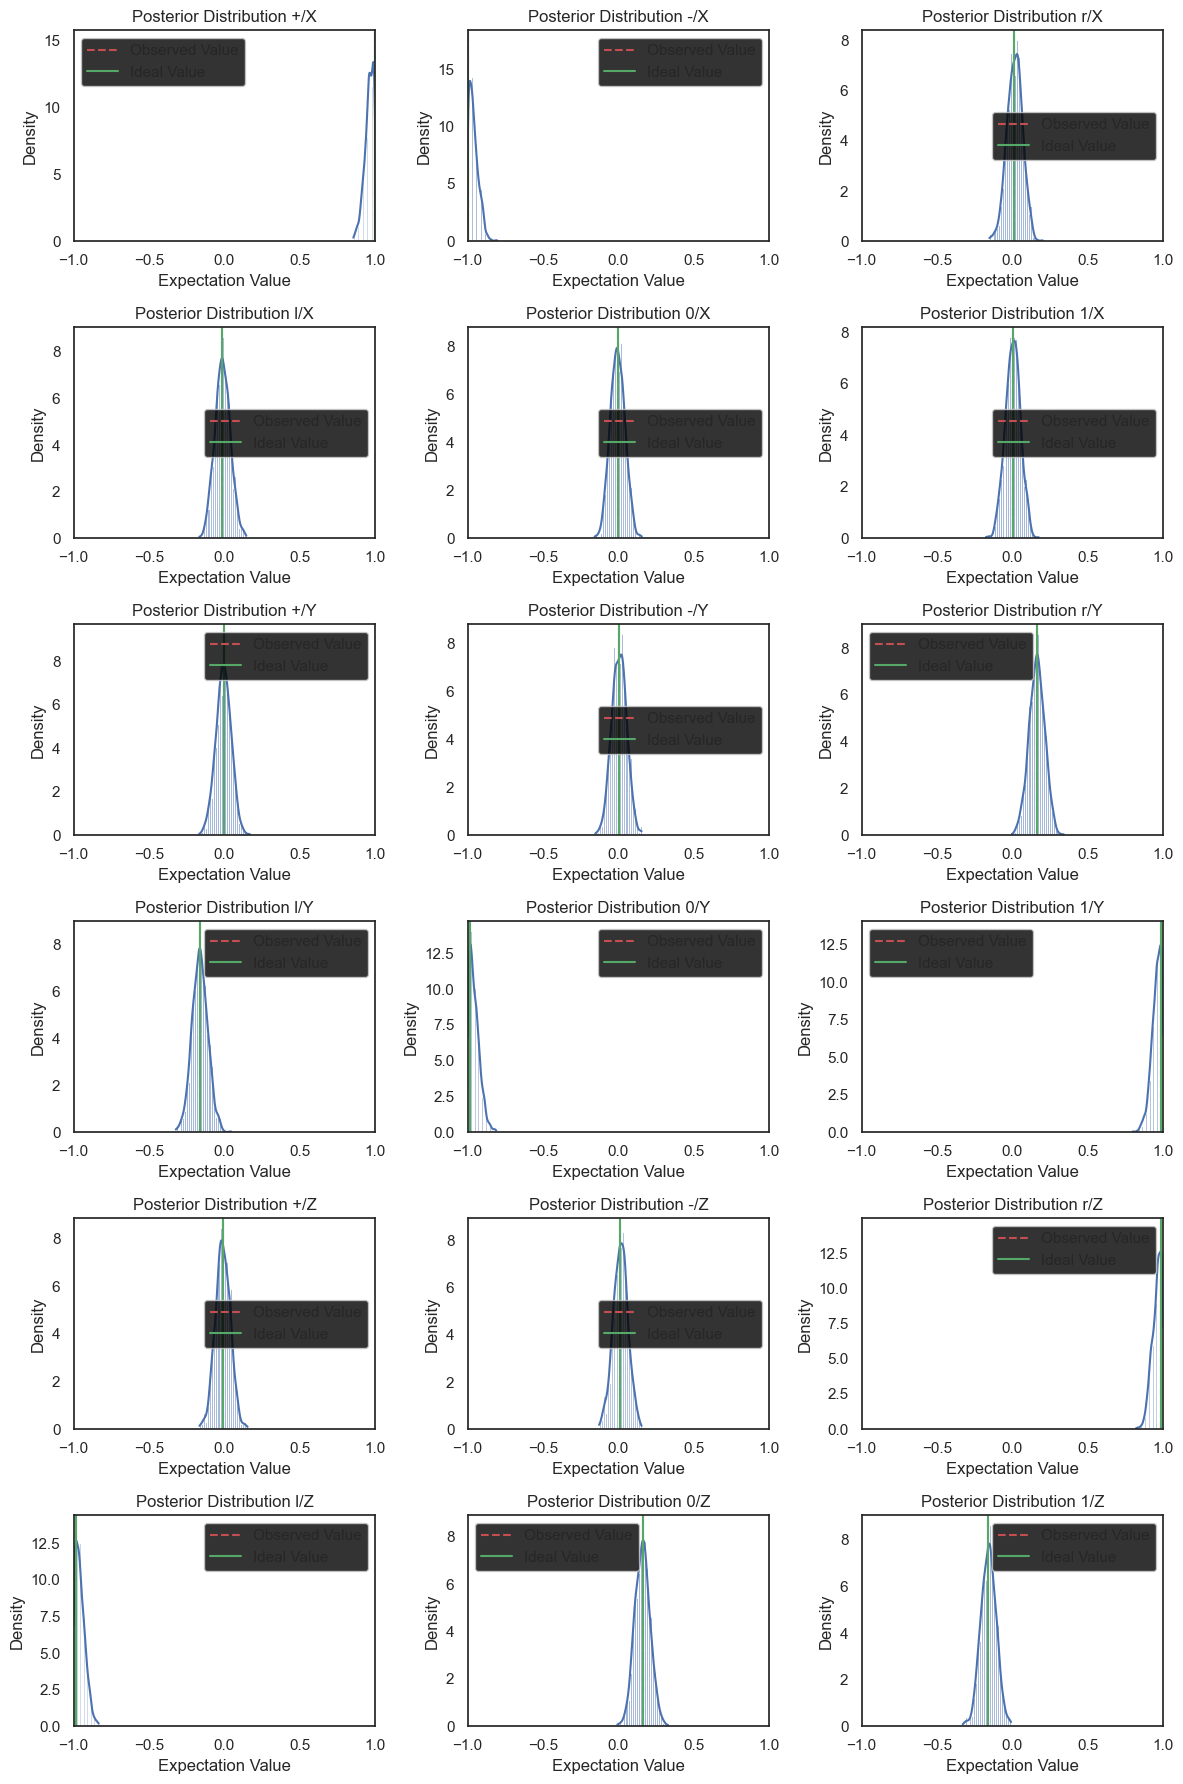

In [90]:
# Sample index to plot for
sample_idx = 60
num_exps = len(sqd.shared.default_expectation_values) # Number of expectation values

# Create a figure with a 3x6 grid of subplots
fig, axes = plt.subplots(6, 3, figsize=(12, 18))
# fig, axes = plt.subplots(3, 6, figsize=(18, 12))

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

for idx, exp in enumerate(sqd.shared.default_expectation_values):
    # Calculate the ideal expectation value with given unitary and current expectation operator
    ideal_exp = sqj.core.calculate_exp(
        unitary=unitaries[sample_idx], 
        operator=exp.get_operator(), 
        initial_state=exp.get_state()
    )

    # Select the subplot
    ax = axes[idx]

    # Plot the histogram of the predictions
    sns.histplot(y_pred[f"obs_{idx}"].T[sample_idx], kde=True, stat="density", ax=ax)

    # Plot vertical lines for the observed and ideal expectation values
    ax.axvline(expvals.T[sample_idx][idx], 0, 1, color="r", linestyle="--", label="Observed Value")
    ax.axvline(ideal_exp, 0, 1, color="g", linestyle="-", label="Ideal Value")
    
    # Set x-axis limits
    ax.set_xlim(-1, 1)
    
    # Add title and labels
    ax.set_title(f'Posterior Distribution {exp.initial_state}/{exp.observable}')
    ax.set_xlabel('Expectation Value')
    ax.set_ylabel('Density')
    ax.legend()

# Hide empty subplots if there are fewer than 18 expectation values
for i in range(num_exps, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axe

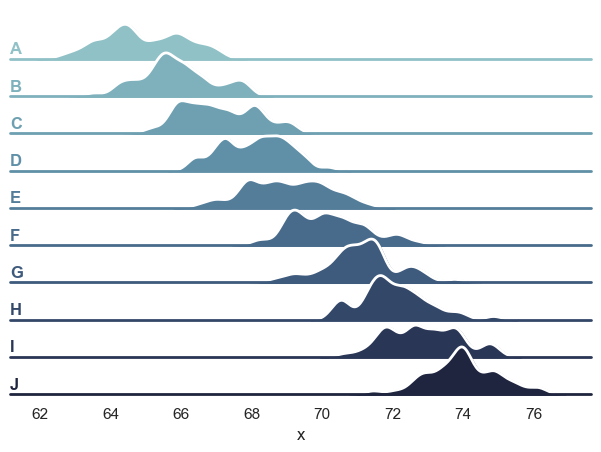

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [50]:
df

,x,g
0,64.038123,A
1,66.147050,B
2,66.370011,C
3,68.791019,D
4,70.583534,E
...,...,...
495,69.358022,F
496,72.212877,G
497,70.474247,H
498,73.251022,I


In [72]:
named_expvals = {
    f'{exp.initial_state}/{exp.observable}': y_pred[f"obs_{idx}"]
for idx, exp in enumerate(sqd.shared.default_expectation_values)}

In [73]:
named_expvals['+/X'].shape

(1000, 100)

In [74]:
# Pandas DataFrame with sample_id, expectation value, realization_id and state/observable as columns
# The keys of named_expvals are the state/observable names and the values in the shape of (realization_id, sample_id)
rows = []
for idx, exp in enumerate(sqd.shared.default_expectation_values):
    for realization_id, realization in enumerate(named_expvals[f'{exp.initial_state}/{exp.observable}']):
        for sample_id, sample in enumerate(realization):
            # print(sample_id, sample, realization_id, exp.initial_state, exp.observable)
            temp_dict = {
                'sample_id': sample_id,
                'expectation_value': float(sample),
                # 'realization_id': realization_id,
                'state_observable': f'{exp.initial_state}/{exp.observable}'
            }
            rows.append(temp_dict)

In [75]:
dataframe = pd.DataFrame(rows)
dataframe

,sample_id,expectation_value,state_observable
0,0,0.956787,+/X
1,1,0.975103,+/X
2,2,0.934363,+/X
3,3,0.996454,+/X
4,4,0.873109,+/X
...,...,...,...
1799995,95,-0.951841,1/Z
1799996,96,-0.093020,1/Z
1799997,97,-0.587242,1/Z
1799998,98,0.320222,1/Z


/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


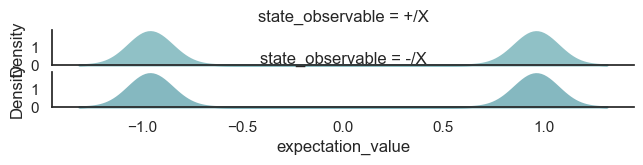

In [83]:
selected_id = 12
sub_df = dataframe[dataframe['sample_id'] == selected_id]
# Select only '+/X' and '-/X' states
sub_df = sub_df[sub_df['state_observable'].isin(['+/X', '-/X'])]
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(18, rot=-.25, light=.7)
g = sns.FacetGrid(sub_df, row="state_observable", hue="state_observable", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, x="expectation_value", data=sub_df,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
# g.map(sns.kdeplot, "expectation_value", clip_on=False, color="w", lw=2, bw_adjust=.5)

<Axes: xlabel='expectation_value', ylabel='Density'>

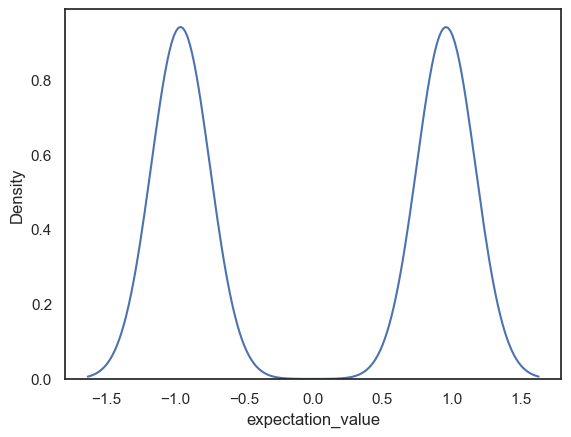

In [80]:
sns.kdeplot(data=sub_df, x="expectation_value")

<Axes: xlabel='expectation_value', ylabel='Density'>

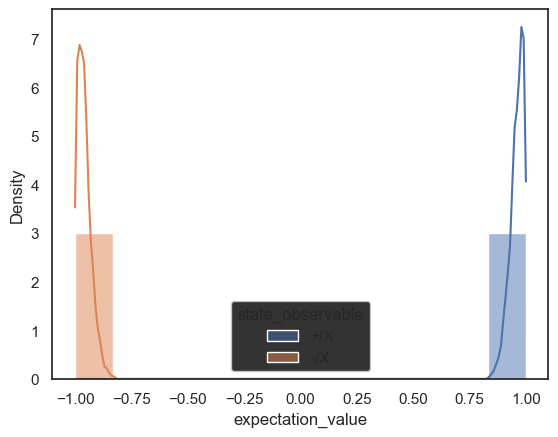

In [87]:
sns.histplot(data=sub_df, x="expectation_value", hue='state_observable', kde=True, stat="density")